In [1]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
if platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
else:
    sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
    sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy import plotting
from neuropy.analyses.placefields import Pf1D
import subjects

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedCheckFailedWarning: Failed to check for latest version of package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [100]:
# Create group data frame with placefield firing in each bin (0:50 = MAZE, 50:100 = reMAZE)
from copy import deepcopy
from neuropy.utils.mathutil import min_max_external_scaler

sessions = subjects.remaze_sess()[1:]  # RatSDay2NSD does not have remaze position info
kw = dict(frate_thresh=0, grid_bin=2)
separate_run_dir = False

tc_all, maze_all, remaze_all = [], [], []
pfcorr_by_dir = {}
for s, sess in enumerate([sessions[0]]):
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()
    neurons = sess.neurons_stable.get_neuron_type("pyr")
    
    # ---- Run direction separated-------
    if separate_run_dir:
        tc_maze, tc_remaze, maze_tc_comb, remaze_tc_comb = [], [], [], []
        for direction in ["up", "down"]:
            maze_run = sess.maze_run[direction]
            pfmaze = Pf1D(neurons, position=sess.maze, epochs=maze_run, **kw)
            maze_tc_comb.append(pfmaze.tuning_curves)
            tc_maze.append(pfmaze.resample_1D(50).tuning_curves)
    
            remaze_run = sess.remaze_run[direction]
            pfremaze = Pf1D(neurons, position=sess.remaze, epochs=remaze_run, **kw)
            remaze_tc_comb.append(pfremaze.tuning_curves)
            tc_remaze.append(pfremaze.resample_1D(50).tuning_curves)
    
        tc_comb = np.hstack((np.vstack(tc_maze), np.vstack(tc_remaze)))
        pfmaze.tuning_curves = np.concatenate(maze_tc_comb, axis=0)
        pfmaze.neuron_ids = np.concatenate((pfmaze.neuron_ids, pfmaze.neuron_ids * -1), axis=0)
        pfremaze.tuning_curves = np.concatenate(remaze_tc_comb, axis=0)
        pfremaze.neuron_ids = np.concatenate((pfremaze.neuron_ids, pfremaze.neuron_ids * -1), axis=0)
        

    # ---- Overall----
    else:
        
        pfmaze = Pf1D(neurons, position=sess.maze, **kw)

In [8]:
sess.paradigm['maze']

1 epochs
Snippet: 
    start   stop label
0   9545  12855  maze

In [93]:
from neuropy.analyses.decoders import Decode1d

decode_maze = Decode1d(neurons=neurons, ratemap=pfmaze, epochs=sess.paradigm['maze'], bin_size=0.2)

In [38]:
np.unique(decode_maze.decoded_position[0])

array([  0. ,   0.5,   1. ,   1.5,   2. ,   2.5,   3. ,   3.5,   4. ,
         4.5,   5. ,   5.5,   6. ,   6.5,   7. ,   7.5,   8. ,   8.5,
         9. ,   9.5,  10. ,  10.5,  11. ,  11.5,  12. ,  12.5,  13. ,
        13.5,  14. ,  14.5,  15. ,  15.5,  16. ,  16.5,  17. ,  17.5,
        18. ,  18.5,  19. ,  19.5,  20. ,  20.5,  21. ,  21.5,  22. ,
        22.5,  23. ,  23.5,  24. ,  24.5,  25. ,  25.5,  26. ,  26.5,
        27. ,  27.5,  28. ,  28.5,  29. ,  29.5,  30. ,  30.5,  31. ,
        31.5,  32. ,  32.5,  33. ,  33.5,  34. ,  34.5,  35. ,  35.5,
        36. ,  36.5,  37. ,  37.5,  38. ,  38.5,  39. ,  39.5,  40. ,
        40.5,  41. ,  41.5,  42. ,  42.5,  43. ,  43.5,  44. ,  44.5,
        45.5,  46. ,  46.5,  47. ,  47.5,  49. ,  49.5,  50. ,  50.5,
        51. ,  51.5,  52. ,  52.5,  53. ,  53.5,  54. ,  54.5,  55. ,
        55.5,  56. ,  56.5,  57. ,  57.5,  58. ,  58.5,  59. ,  59.5,
        60. ,  60.5,  61. ,  61.5,  62. ,  62.5,  63. ,  63.5,  64. ,
        64.5,  65. ,

In [103]:
sess.maze.time.shape

(198601,)

In [110]:
### Write code to get error in decoded position!!!

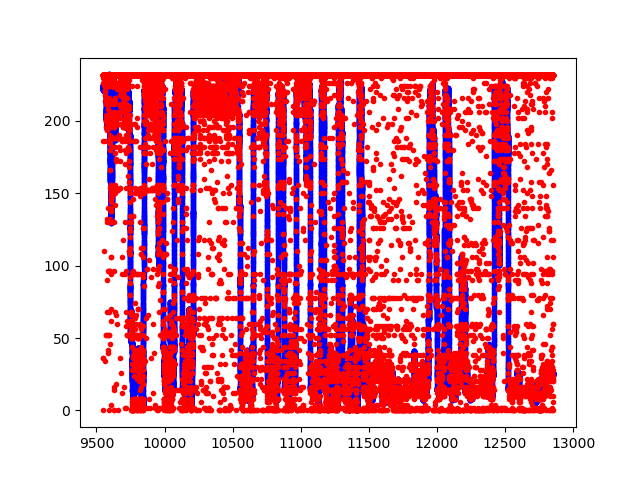

In [107]:
%matplotlib widget
_, ax = plt.subplots()
speed_thresh = pfmaze.speed > pfmaze.speed_thresh
ax.plot(sess.maze.time[speed_thresh], sess.maze.x[speed_thresh], 'b.')
t_decode = sess.paradigm['maze'].starts[0] + np.arange(decode_maze.nbins_epochs[0]) * decode_maze.bin_size
ax.plot(t_decode, decode_maze.decoded_position[0], 'r.')

In [109]:
decode_maze.decoded_position[0].shape

(16549,)

In [101]:
pfmaze.speed

array([0.        , 0.        , 0.        , ..., 3.34251376, 2.54314726,
       1.39062614])

<Axes: >

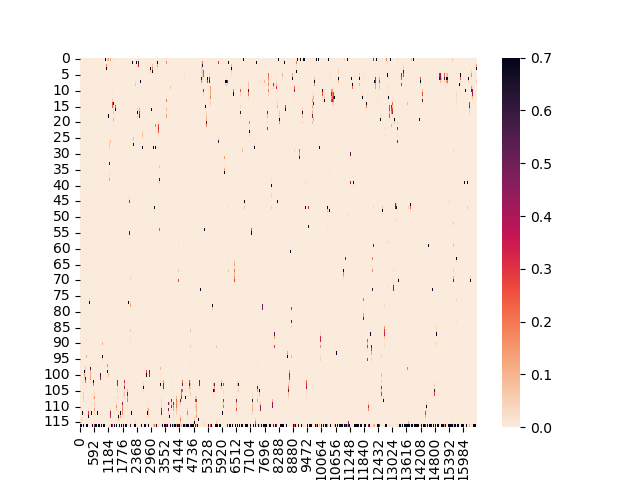

In [94]:
_, ax = plt.subplots()
sns.heatmap(decode_maze.posterior[0], ax=ax, vmax=0.7, cmap='rocket_r')

In [81]:
decode_maze.posterior[0].reshape(-1).min()

6.696988073786172e-91

In [72]:
decode_maze.decoded_position[0].shape

(16549,)

In [67]:
sess.paradigm['maze'].durations


array([3310])

In [55]:
decode_maze.decoded_position[0].shape[0] * 0.2

3309.8

In [29]:
sess.maze.x.shape

(198601,)

In [28]:
decode_maze.decoded_position[0].shape

(165499,)

In [4]:
pfmaze